# DM modeling of Terzan 5 pulsars

This notebook analyzes DM variations in the timing of five of the brightests pulsars in the Terzan 5 globular cluster using PINT. It fits DMX parameters to all pulsars, estimates a common DM (mean DM) ammong these pulsas, applies a Gaussian Process regression per pulsar, and visualizes the residuals.

### Goals:
The main goal is to compare two different DM models: DMX applied separately to each pulsar vs a common DM model + Gaussian Process (GP) fitting. The comparison is performed using the Akaike Information Criterion (AIC).

## DMX for all pulsars separately
We first obtain the DMX model for each of the pulsars 'manually', we use pulsar Ter5 M as a test case.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from functools import reduce
from scipy import stats

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, RationalQuadratic

import pint.logging
from pint.models import get_model_and_toas, dispersion_model
from pint import residuals, fitter, utils

pint.logging.setup(level="INFO")

%matplotlib widget

In [2]:
# Input files

pars = ["1748-2446C.par", "1748-2446O.par", "1748-2446E.par", "1748-2446N.par", "1748-2446M.par"]
tims = ["new_Ter5C.tim", "new_Ter5O.tim", "new_Ter5E.tim", "new_Ter5N.tim", "new_Ter5M.tim"]
colors = ['darkgoldenrod', 'b', 'r', 'c', 'm']
bin_width = 50  # days 

In [3]:
# ---------- HELPER FUNCTIONS ----------                                                                                       
def weighted_avg(values, errors):
    mask = ~np.isnan(values) & ~np.isnan(errors)
    if np.any(mask):
        weights = 1 / np.square(errors[mask])
        return np.sum(values[mask] * weights) / np.sum(weights)
    return np.nan

def weighted_avg_error(errors):
    mask = ~np.isnan(errors)
    if np.any(mask):
        weights = 1 / np.square(errors[mask])
        return np.sqrt(1 / np.sum(weights))
    return np.nan

def compute_dmx_bins(allmjds, span_days=bin_width):
    mjd_min, mjd_max = np.min(allmjds), np.max(allmjds)
    start_mjds = np.arange(mjd_min, mjd_max, span_days)
    end_mjds = np.minimum(start_mjds + span_days, mjd_max)
    valid = [(s, e) for s, e in zip(start_mjds, end_mjds) if np.any((allmjds >= s) & (allmjds < e))]
    return np.array([v[0] for v in valid]), np.array([v[1] for v in valid])

def compute_dm_residuals(t, m):
    resids = residuals.Residuals(t, m)
    time_resids = resids.calc_time_resids().value
    freqs = t.table['freq'].data
    errors = t.table['error'].value * 1e-6
    dm_resid = (time_resids * freqs**2) / 4.15e3
    dm_resid_err = (errors * freqs**2) / 4.15e3
    return dm_resid, dm_resid_err

INFO     (pint.toa                      ): Reading TOAs from the picklefile for `new_Ter5C.tim`
INFO     (pint.observatory              ): Applying GPS to UTC clock correction (~few nanoseconds)
INFO     (pint.observatory              ): Loading global GPS clock file
INFO     (pint.observatory              ): Using global clock file for gps2utc.clk with bogus_last_correction=False
INFO     (pint.observatory              ): Applying TT(TAI) to TT(BIPM2021) clock correction (~27 us)
INFO     (pint.observatory              ): Loading BIPM clock version bipm2021
INFO     (pint.observatory              ): Using global clock file for tai2tt_bipm2021.clk with bogus_last_correction=False
INFO     (pint.observatory              ): Using global clock file for time_gbt.dat with bogus_last_correction=False
INFO     (pint.observatory.topo_obs     ): Applying observatory clock corrections for observatory='gbt'.
INFO     (pint.solar_system_ephemerides ): Set solar system ephemeris to de440 through as

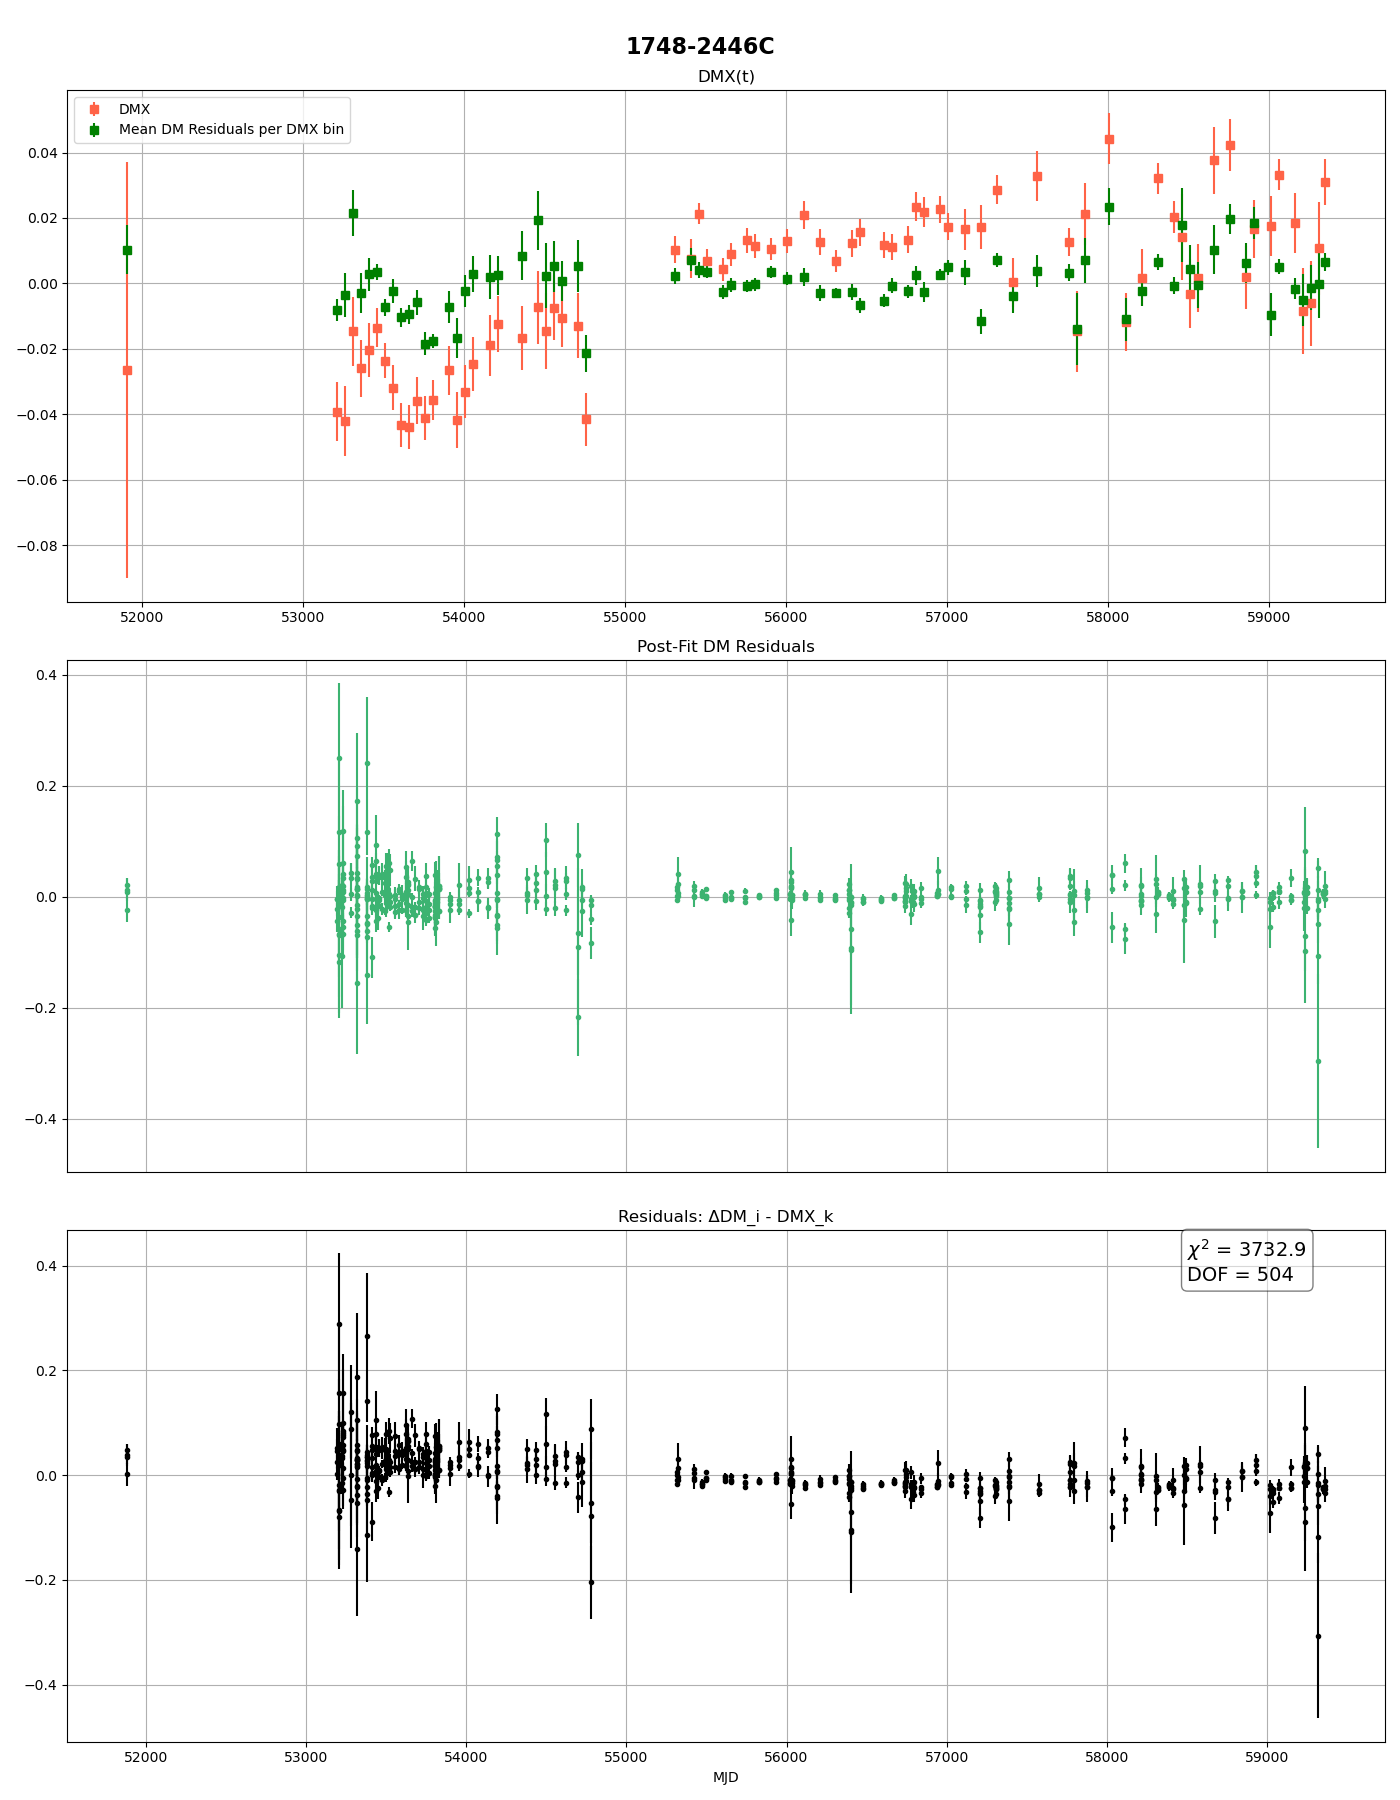

INFO     (pint.models.parameter         ): Parameter PBDOT's value will be scaled by 1e-12
INFO     (pint.models.parameter         ): Parameter PBDOT's value will be scaled by 1e-12
INFO     (pint.toa                      ): Reading TOAs from the picklefile for `new_Ter5O.tim`
WARNING  (pint.logging                  ): /home/uwm/vleescho/Data15/vleescho/conda/envs/IPTA_Env/lib/python3.9/site-packages/pint/fitter.py:2050 DegeneracyWarning: Parameter degeneracy; the following linear combination yields almost no change: 1.0*DM + 2.8456003775163558e-11*F10 + 2.0574397837874347e-11*F7 + -1.2468607801815606e-11*F8 + -1.5039631616887536e-11*F11 + -1.6725325809097423e-11*F9 + -0.013253199858741804*DMX_0016 + -0.014100564772454931*DMX_0019 + -0.015013634785816521*DMX_0017 + -0.015428757066254718*DMX_0015 + -0.016249313596621153*DMX_0018 + -0.016322285518788705*DMX_0006 + -0.016374529440720636*DMX_0003 + -0.017606209771277585*DMX_0012 + -0.018333093656334478*DMX_0001 + -0.01972704647174067*DMX_0

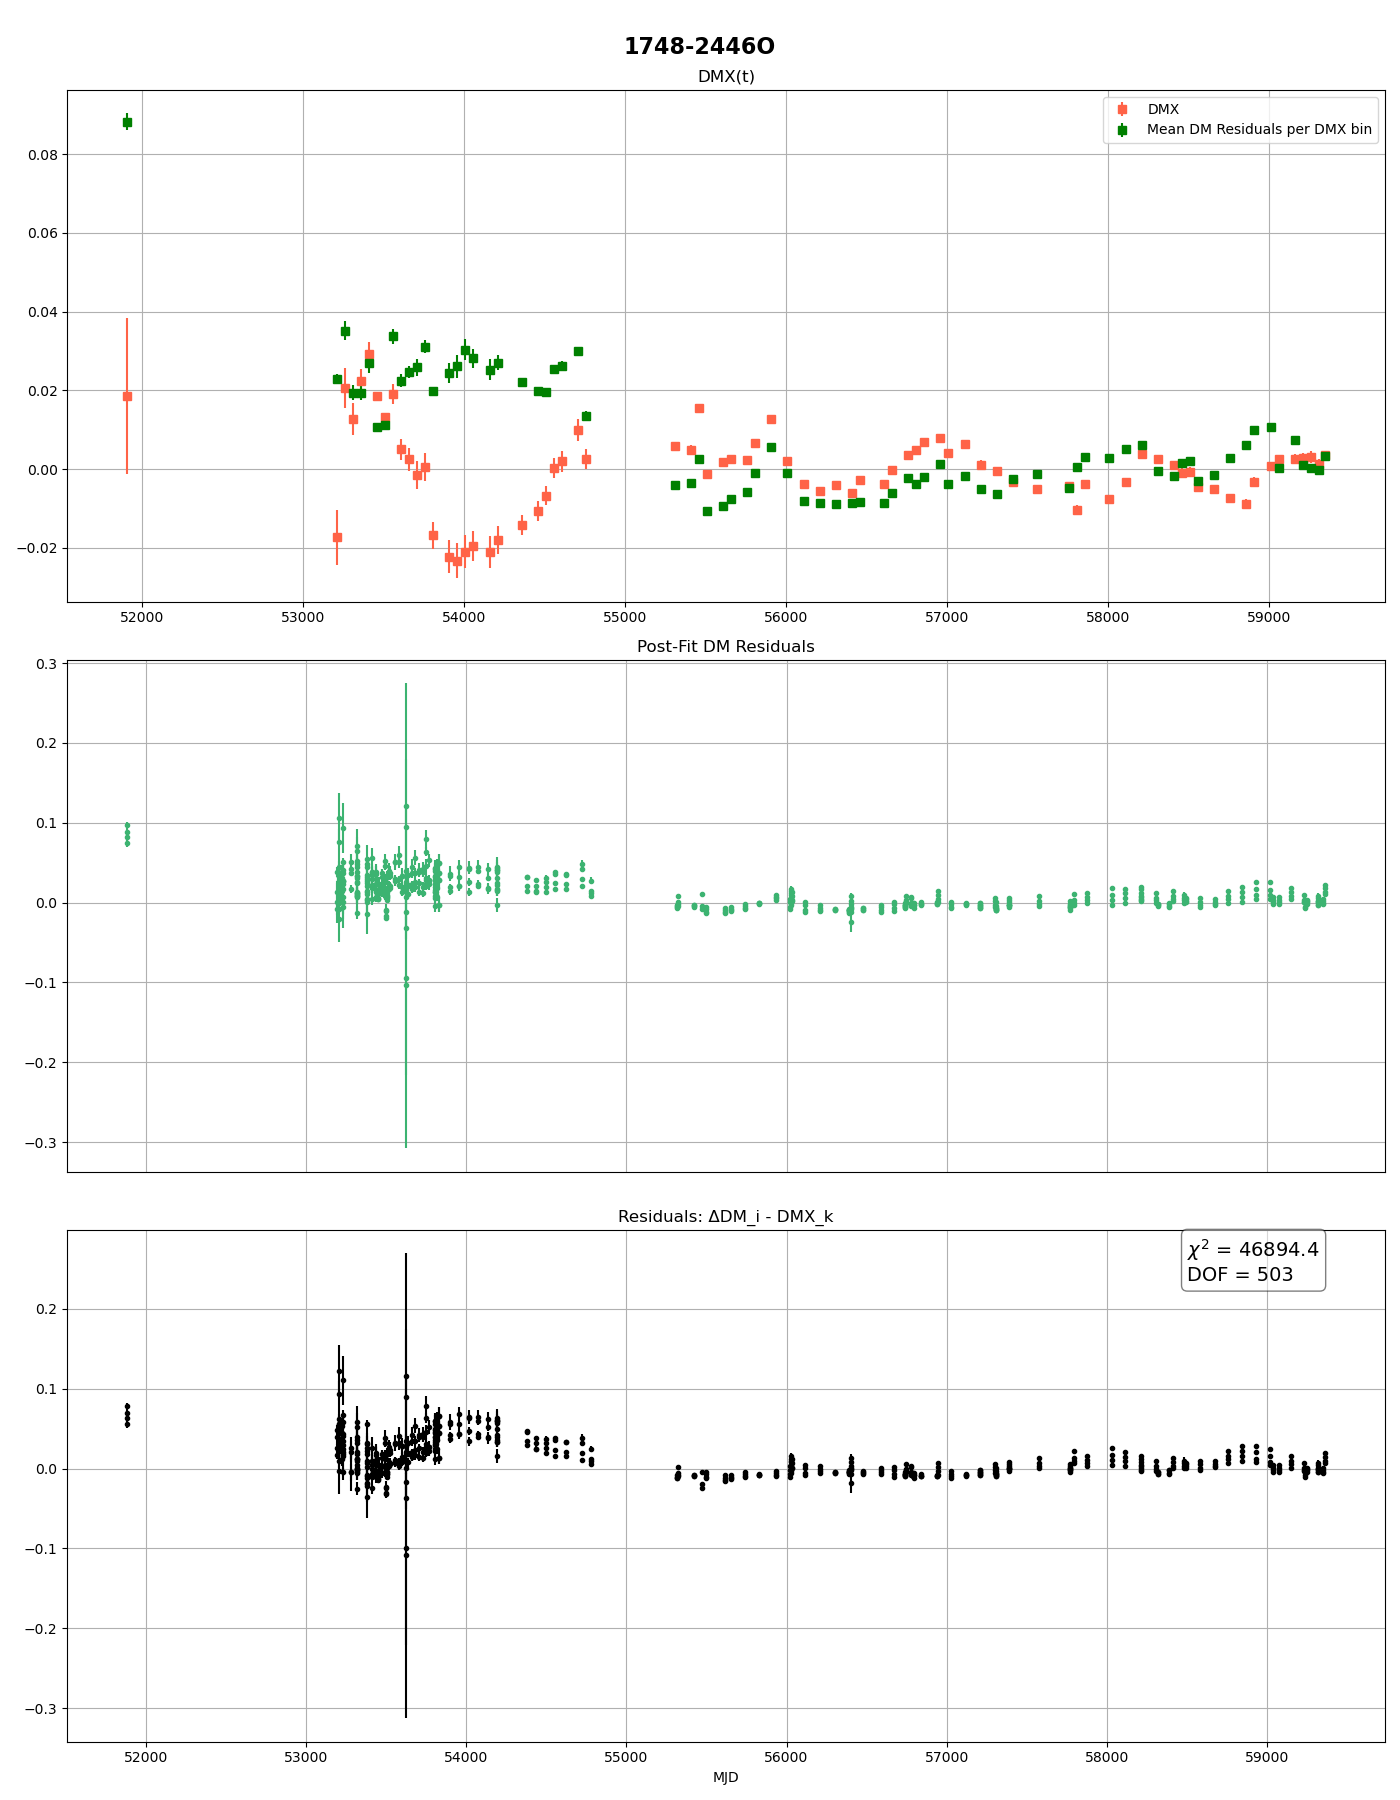

INFO     (pint.models.parameter         ): Parameter PBDOT's value will be scaled by 1e-12
INFO     (pint.models.parameter         ): Parameter PBDOT's value will be scaled by 1e-12
INFO     (pint.toa                      ): Reading TOAs from the picklefile for `new_Ter5E.tim`
WARNING  (pint.logging                  ): /home/uwm/vleescho/Data15/vleescho/conda/envs/IPTA_Env/lib/python3.9/site-packages/pint/fitter.py:2050 DegeneracyWarning: Parameter degeneracy; the following linear combination yields almost no change: 0.23310113549562267*DMX_0061 + 0.2153452170645604*DMX_0032 + 0.21212199812062882*DMX_0041 + 0.2098426223397237*DMX_0037 + 0.20931262941798515*DMX_0045 + 0.20686929159157508*DMX_0034 + 0.19683586497393155*DMX_0043 + 0.19660511585753607*DMX_0038 + 0.19222790669685202*DMX_0071 + 0.18564195687949595*DMX_0047 + 0.18025153297662477*DMX_0039 + 0.17989724091123005*DMX_0062 + 0.17783663791205173*DMX_0028 + 0.17294365305926265*DMX_0044 + 0.1699265701681874*DMX_0048 + 0.1679021686828

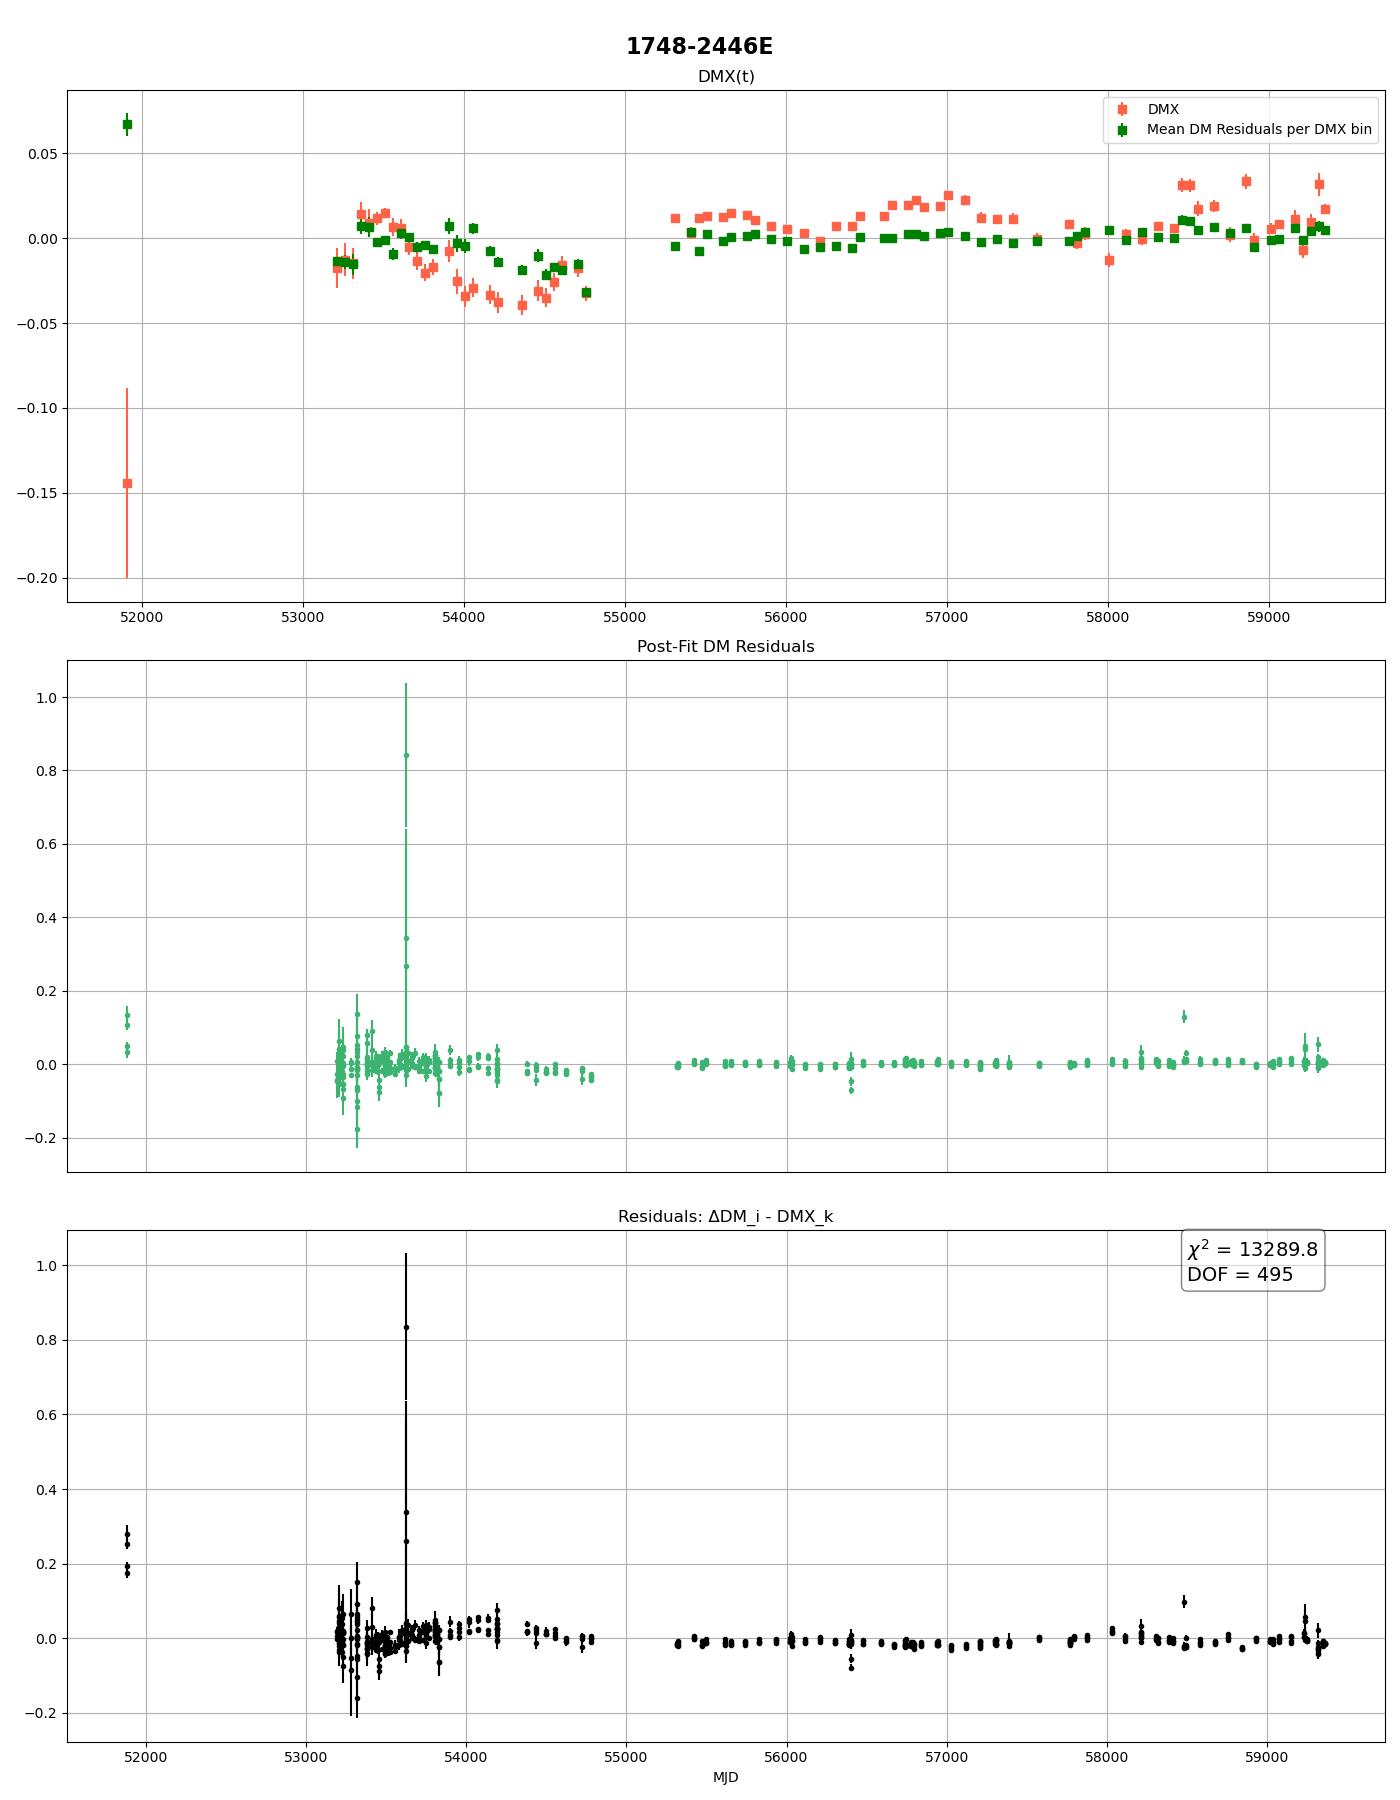

INFO     (pint.models.parameter         ): Parameter PBDOT's value will be scaled by 1e-12
INFO     (pint.models.parameter         ): Parameter PBDOT's value will be scaled by 1e-12
INFO     (pint.toa                      ): Reading TOAs from the picklefile for `new_Ter5N.tim`
WARNING  (pint.logging                  ): /home/uwm/vleescho/Data15/vleescho/conda/envs/IPTA_Env/lib/python3.9/site-packages/pint/fitter.py:2050 DegeneracyWarning: Parameter degeneracy; the following linear combination yields almost no change: 0.271622906166785*DMX_0048 + 0.2168072195175172*DMX_0034 + 0.20987666404559974*DMX_0035 + 0.20341377560374854*DMX_0071 + 0.1978569302824672*DMX_0061 + 0.19606757906588052*DMX_0045 + 0.18792133081646356*DMX_0055 + 0.1851879588285571*DMX_0076 + 0.17355415189004528*DMX_0033 + 0.17075252332304644*DMX_0036 + 0.16599677796989412*DMX_0038 + 0.1641773002686111*DMX_0039 + 0.15374027060749354*DMX_0041 + 0.15011717596234453*DMX_0028 + 0.14523395440144313*DMX_0062 + 0.1430702015087548

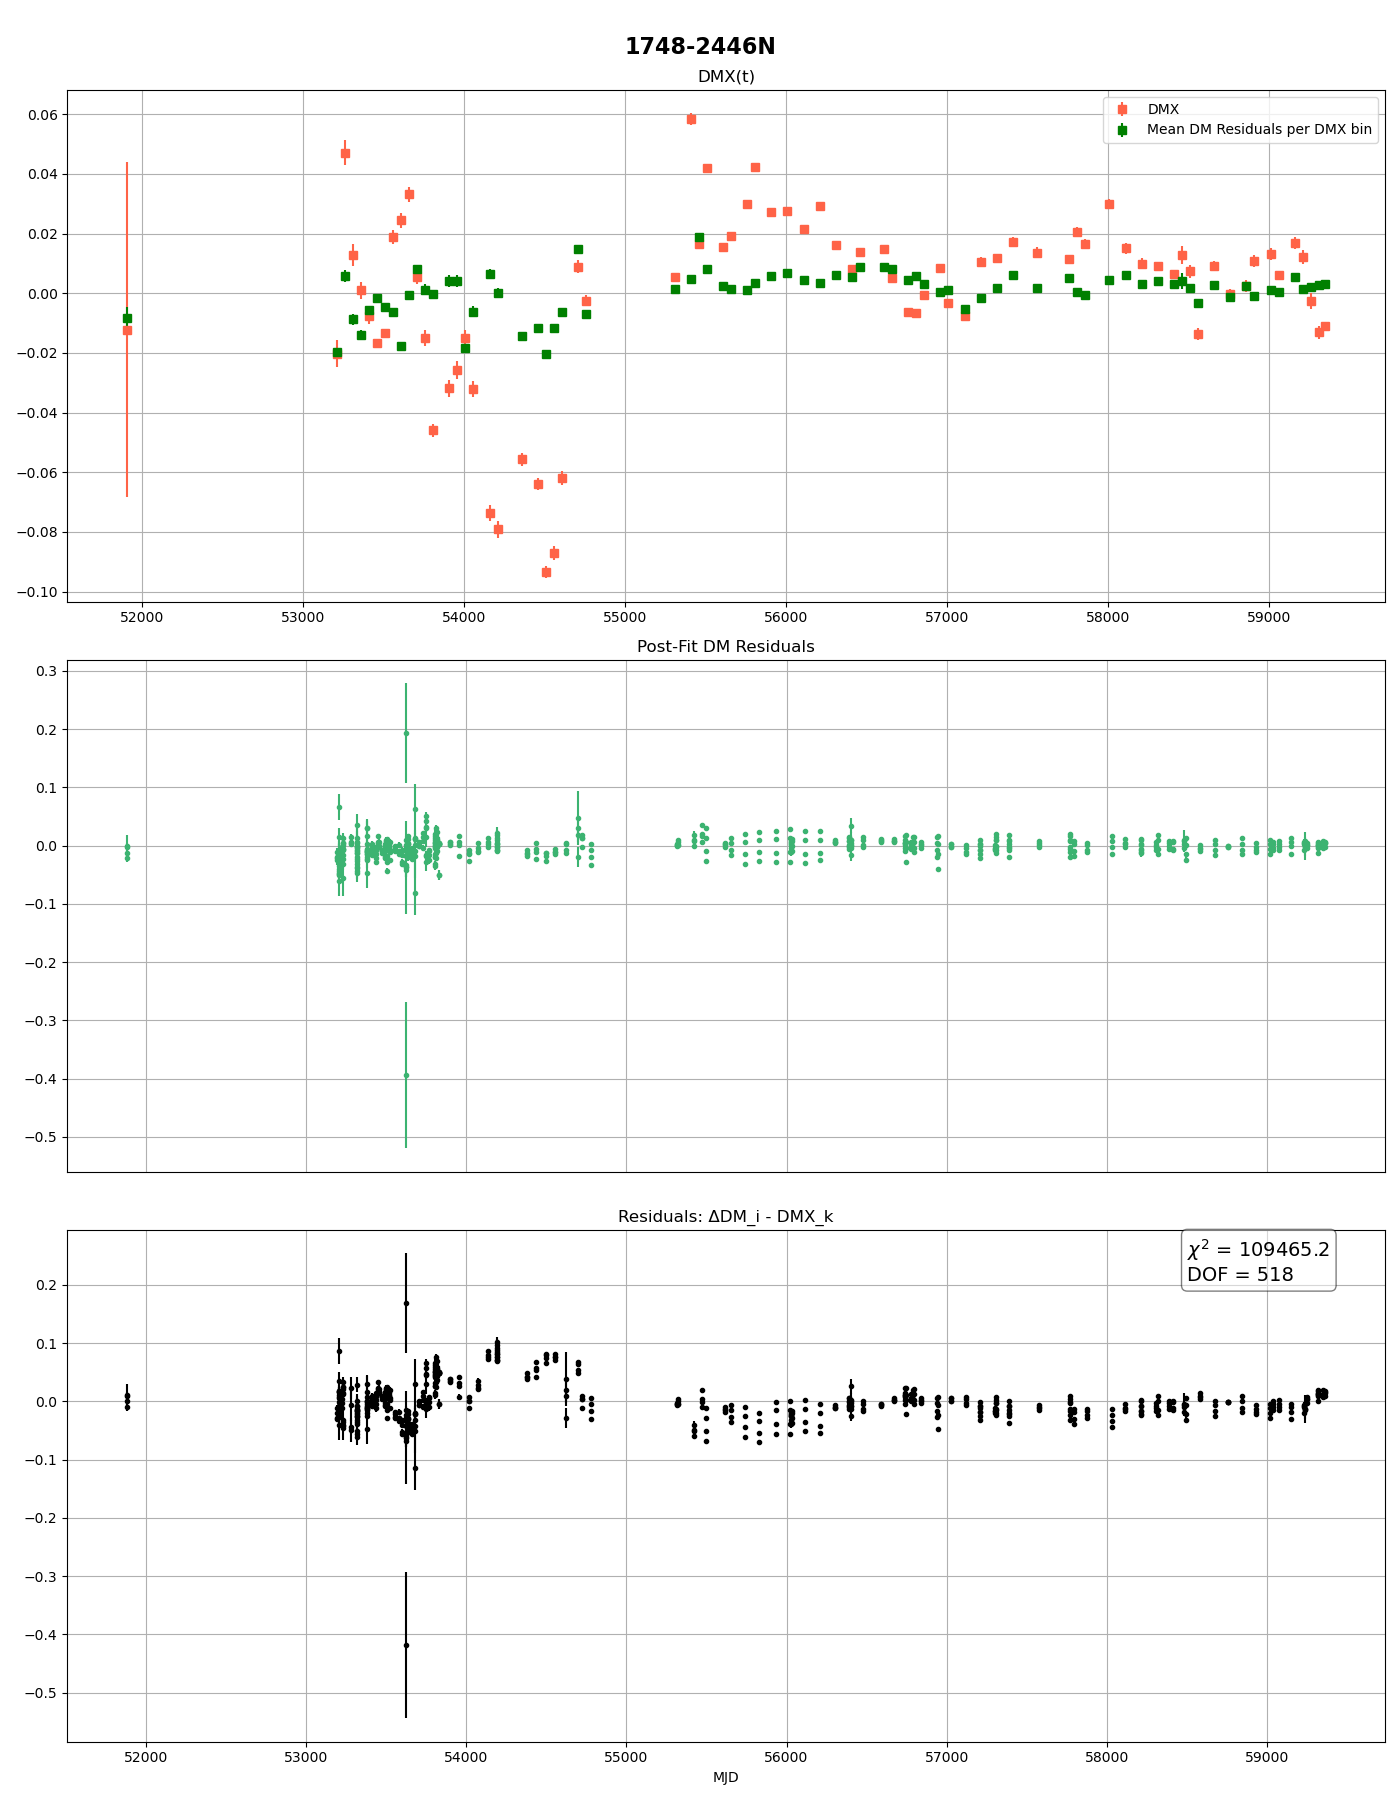

INFO     (pint.models.parameter         ): Parameter PBDOT's value will be scaled by 1e-12
INFO     (pint.models.parameter         ): Parameter PBDOT's value will be scaled by 1e-12
INFO     (pint.toa                      ): Reading TOAs from the picklefile for `new_Ter5M.tim`
WARNING  (pint.logging                  ): /home/uwm/vleescho/Data15/vleescho/conda/envs/IPTA_Env/lib/python3.9/site-packages/pint/fitter.py:2050 DegeneracyWarning: Parameter degeneracy; the following linear combination yields almost no change: 1.0*DM + -0.024586666801100474*DMX_0001 + -0.02969191473402231*DMX_0003 + -0.030211749887697877*DMX_0004 + -0.03577153437491506*DMX_0024 + -0.03666712545641617*DMX_0015 + -0.03691652312939636*DMX_0025 + -0.04122440322584631*DMX_0019 + -0.04238849701603504*DMX_0020 + -0.04306512671222066*DMX_0057 + -0.043813728197979344*DMX_0016 + -0.04707121604097684*DMX_0017 + -0.048402756846290515*DMX_0023 + -0.04967697958545265*DMX_0009 + -0.05040493394711745*DMX_0063 + -0.0532997637069

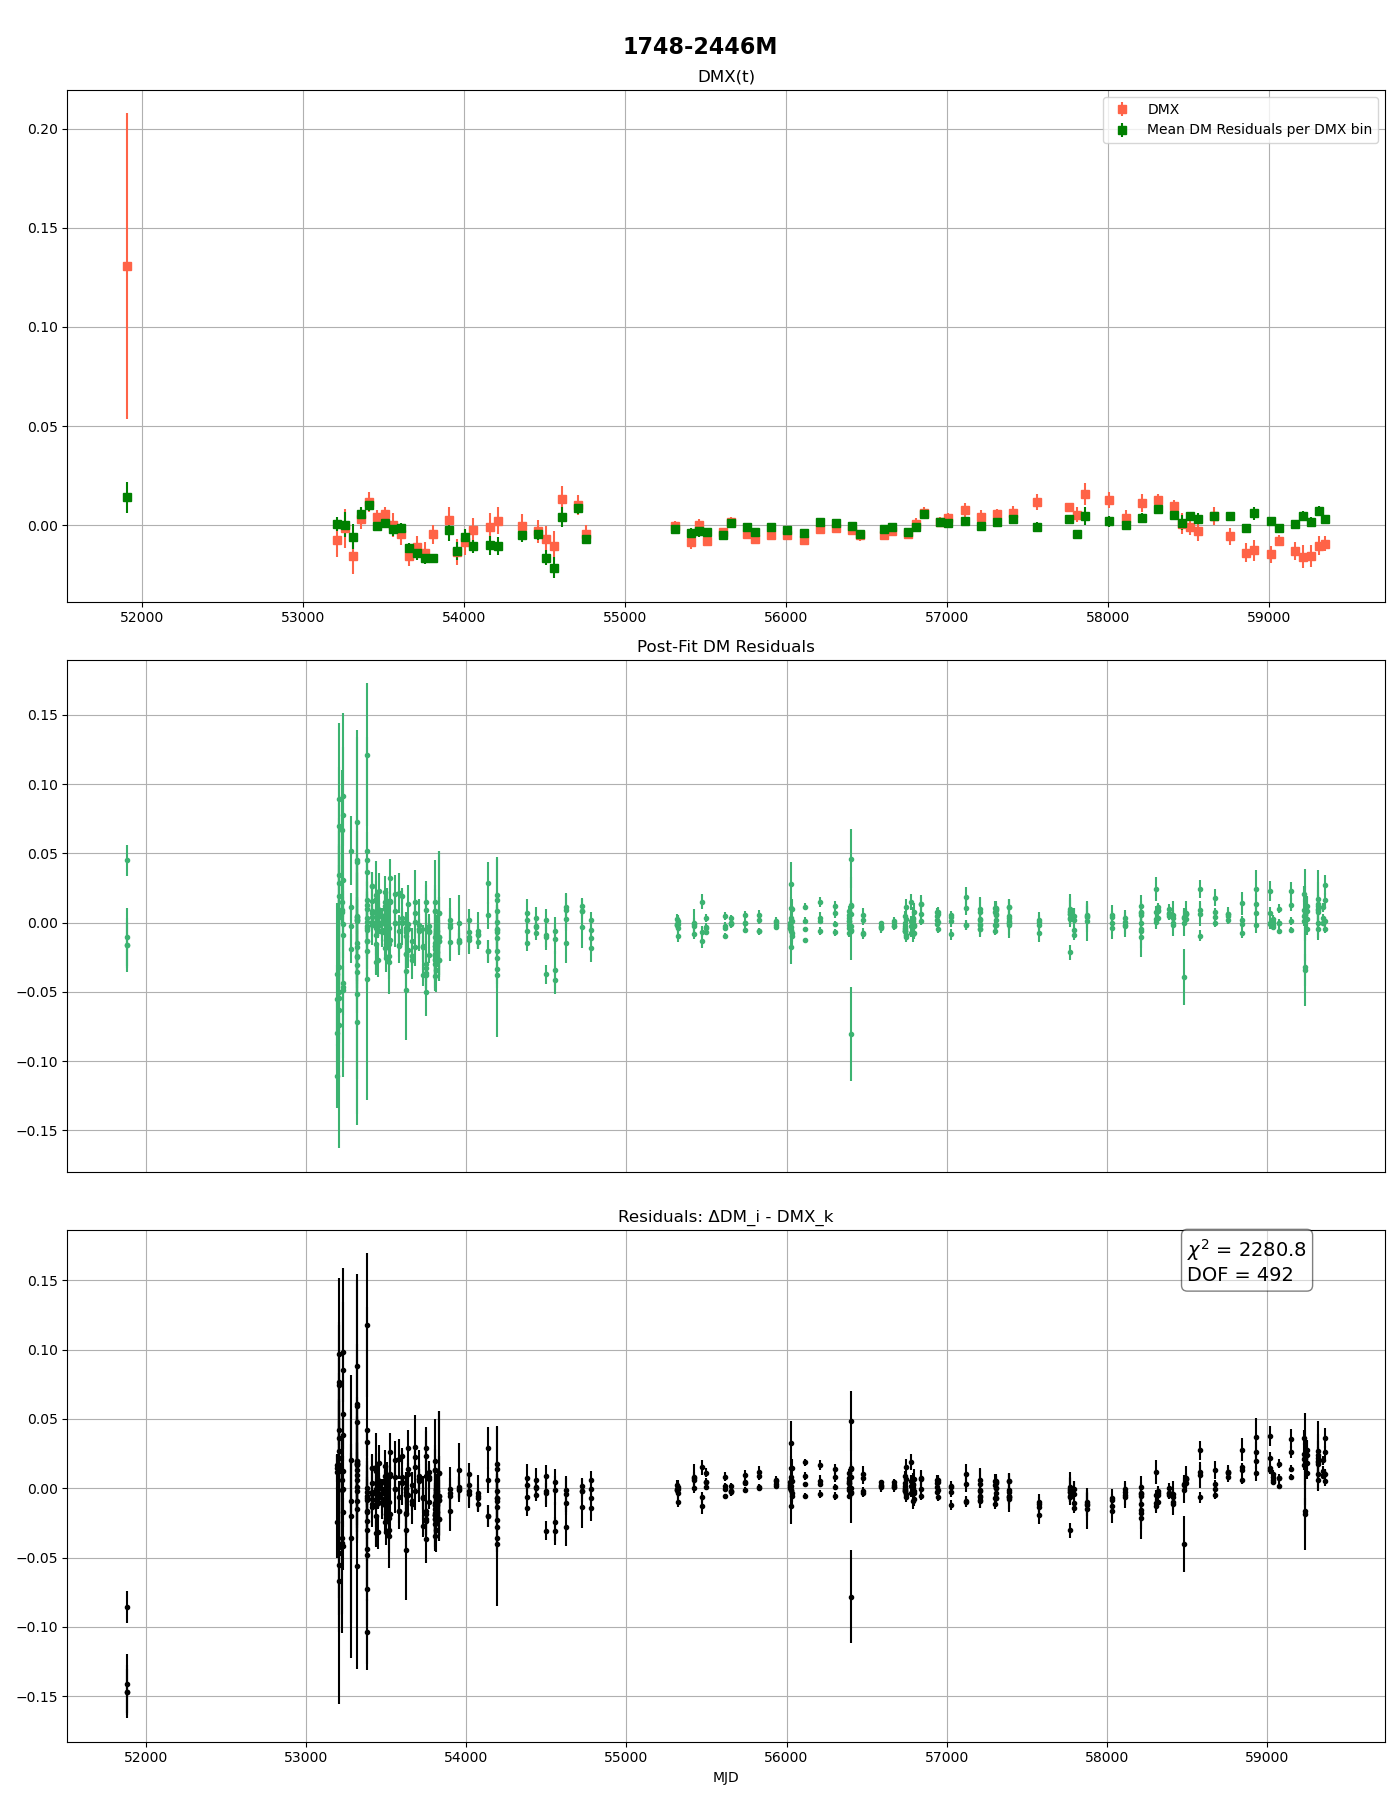

In [4]:
# ---------- PROCESS DMX MODEL EACH PULSAR ----------                                                                                    
results_DMX = []
dmx_data_all = {}

chi2_DMX_list = []
all_toas_list = []
dmx_epoch_count = None
# We first obtain the DMX model for each of the pulsars
for par, tim, color in zip(pars, tims, colors):
    model, toas = get_model_and_toas(par, tim, usepickle=True)
    mjds = toas.get_mjds().value
    start_mjds, end_mjds = compute_dmx_bins(mjds, span_days=bin_width)
    all_toas_list.append(toas)

    # Clean DMX terms                                                                                                          
    for param in list(model.params):
        if param.startswith("DMX"):
            model.remove_param(param)

    # Add DMX component                                                                                                        
    dmx_model = dispersion_model.DispersionDMX()
    dmx_model.DMXR1_0001.value = start_mjds[0]
    dmx_model.DMXR2_0001.value = end_mjds[0]
    dmx_model.add_DMX_ranges(start_mjds[1:], end_mjds[1:], dmxs=0, frozens=False)
    model.add_component(dmx_model)

    fit = fitter.WLSFitter(toas, model)
    fit.fit_toas(maxiter=1)
    #fit.print_summary()

    # Obtain the DM residuals
    dm_resid, dm_resid_err = compute_dm_residuals(toas, model)
    dmx = utils.dmxparse(fit)

    means, errors, corrected = [], [], []
    dmxr1s, dmxr2s, dmx_values = dmx['r1s'], dmx['r2s'], dmx['dmxs'].value
    all_dmresids, all_dmerrs, dm_resid_perbin = [], [], []

    # Iterate over each DM resid bin and subtract the corresponding DMX value
    for r1, r2, dmx_val in zip(dmxr1s, dmxr2s, dmx_values):
        mask = (toas.table['mjd_float'] >= r1) & (toas.table['mjd_float'] <= r2)
        dmresid_bin = dm_resid[mask]
        dmerr_bin = dm_resid_err[mask]
        dm_resid_perbin.append(dmresid_bin)
        all_dmresids.append(dmresid_bin - dmx_val)
        all_dmerrs.append(dmerr_bin)
        
        if len(dmresid_bin) > 0:
            weights = 1.0 / dmerr_bin**2
            mean = np.sum(dmresid_bin * weights) / np.sum(weights)
            err = np.sqrt(1.0 / np.sum(weights))
            means.append(mean)
            errors.append(err)

    flat_dmcorrected = np.concatenate(all_dmresids)
    flat_dmerrors = np.concatenate(all_dmerrs)
    chi2 = np.sum(flat_dmcorrected**2 / flat_dmerrors**2)
    dof = len(flat_dmcorrected) - len(dmx_values)
    chi2_red = chi2/dof

    chi2_DMX_list.append(chi2)
    if dmx_epoch_count is None:
        dmx_epoch_count = len(dmx["dmxeps"])
    
    # Save 3-panel plot                                                                                                        
    fig, ax = plt.subplots(nrows=3, figsize=(14, 18))
    ax[0].errorbar(dmx['dmxeps'], dmx['dmxs'], yerr=dmx['dmx_verrs'], fmt="s", color="tomato", label="DMX")
    ax[0].errorbar(dmx['dmxeps'], means, yerr=errors, fmt="s", color="green", label="Mean DM Residuals per DMX bin")
    ax[0].set_title("DMX(t)")
    ax[0].legend() 
    ax[0].grid(True)

    ax[1].errorbar(toas.table['mjd_float'], dm_resid, yerr=dm_resid_err, fmt=".", color='mediumseagreen')
    ax[1].set_title("Post-Fit DM Residuals") 
    ax[1].tick_params(axis='x', bottom=False, labelbottom=False)
    ax[1].grid(True)
    
    ax[2].errorbar(toas.get_mjds().value, flat_dmcorrected, yerr=flat_dmerrors, fmt=".", color="black")
    ax[2].set_title("Residuals: ΔDM_i - DMX_k")
    ax[2].set_xlabel("MJD")
    ax[2].text(0.85, 0.90, f"$\\chi^2$ = {chi2:.1f}\nDOF = {dof}", transform=ax[2].transAxes,
               fontsize=14, bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
    ax[2].grid(True)

    fig.suptitle(f"{model.PSR.value}", fontsize=16, fontweight="bold")
    plt.tight_layout() 
    plt.subplots_adjust(top=0.95)
    plt.savefig(f"{model.PSR.value}_DMXresiduals.pdf", dpi=300)
    plt.show()

    results_DMX.append({
        "name": model.PSR.value,
        "epochs": dmx["dmxeps"],
        "dm_means": np.array(means),
        "dm_errors": np.array(errors),
        "color": color,
        "chi2": chi2,
        "dof": dof,
        "chi2_red": chi2_red,
        "toas": toas,
        "dm_resid": dm_resid,
        "dm_resid_err": dm_resid_err,
        "dm_resid_perbin": dm_resid_perbin,
        "model": model
    })

## Common DM + Gaussian Process (GP)

First we extract the common DM over all pulsars: This section computes the mean DM residuals over all pulsars. Both the data and the plot are generated.

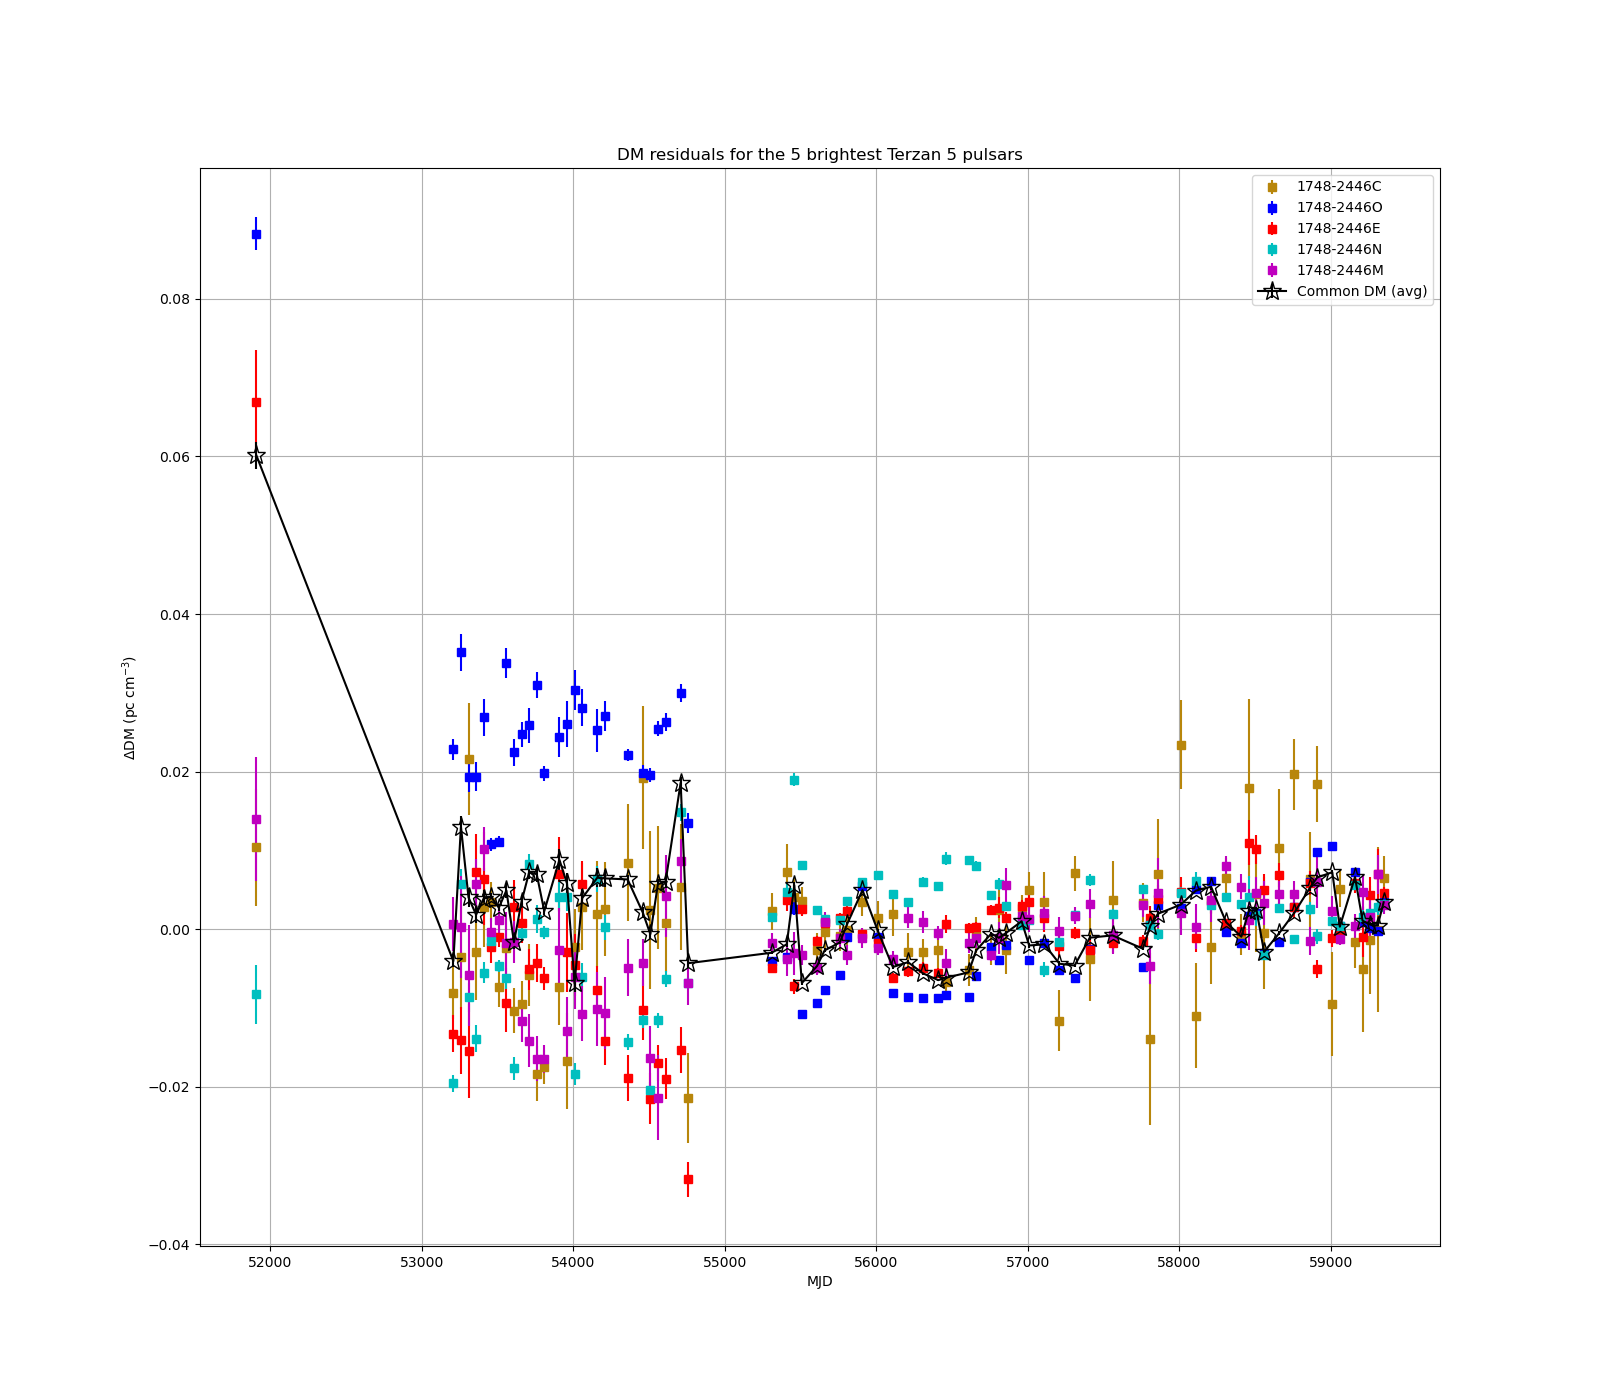

In [5]:
# ---------- COMMON DM ----------                                                                                          
dm_epochs = np.array([r["epochs"] for r in results_DMX])
dm_means = np.array([r["dm_means"] for r in results_DMX])
dm_errors = np.array([r["dm_errors"] for r in results_DMX])
bin_centers = np.mean(dm_epochs, axis=0)

binned_means = [weighted_avg(dm_means[:, i], dm_errors[:, i]) for i in range(dm_means.shape[1])]
binned_errors = [weighted_avg_error(dm_errors[:, i]) for i in range(dm_errors.shape[1])]

np.savetxt("commonDM_Ter5data_5psrs.txt",
           np.column_stack([bin_centers, binned_means, binned_errors]),
           header="Bin_MJD, Avg_DM, Avg_Error", fmt="%.6f")

fig, ax = plt.subplots(figsize=(16, 14))
for r in results_DMX:
    ax.errorbar(r["epochs"], r["dm_means"], yerr=r["dm_errors"], fmt='s', color=r["color"], label=r["name"])

ax.errorbar(bin_centers, binned_means, yerr=binned_errors, fmt='*-', color='black',
            markeredgecolor='black', markerfacecolor='None', markersize=14, label="Common DM (avg)")
ax.set_title("DM residuals for the 5 brightest Terzan 5 pulsars")
ax.set_xlabel("MJD"); ax.set_ylabel(r"$\Delta$DM (pc cm$^{-3}$)")
ax.legend(); ax.grid()
plt.savefig("CommonDM_5psrs_Ter5.pdf", dpi=300)

Secondly, we use the results of the common DM to subract it from the DM residuals of each pulsar, and then fit a Gaussian Process Regression (GPR) kernel to each pulsa. This is done separately for each pulsar, as the optimal kernel may differ between them. 

WARNING  (pint.logging                  ): /home/uwm/vleescho/Data15/vleescho/conda/envs/IPTA_Env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:429 ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
WARNING  (pint.logging                  ): /home/uwm/vleescho/Data15/vleescho/conda/envs/IPTA_Env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:419 ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.


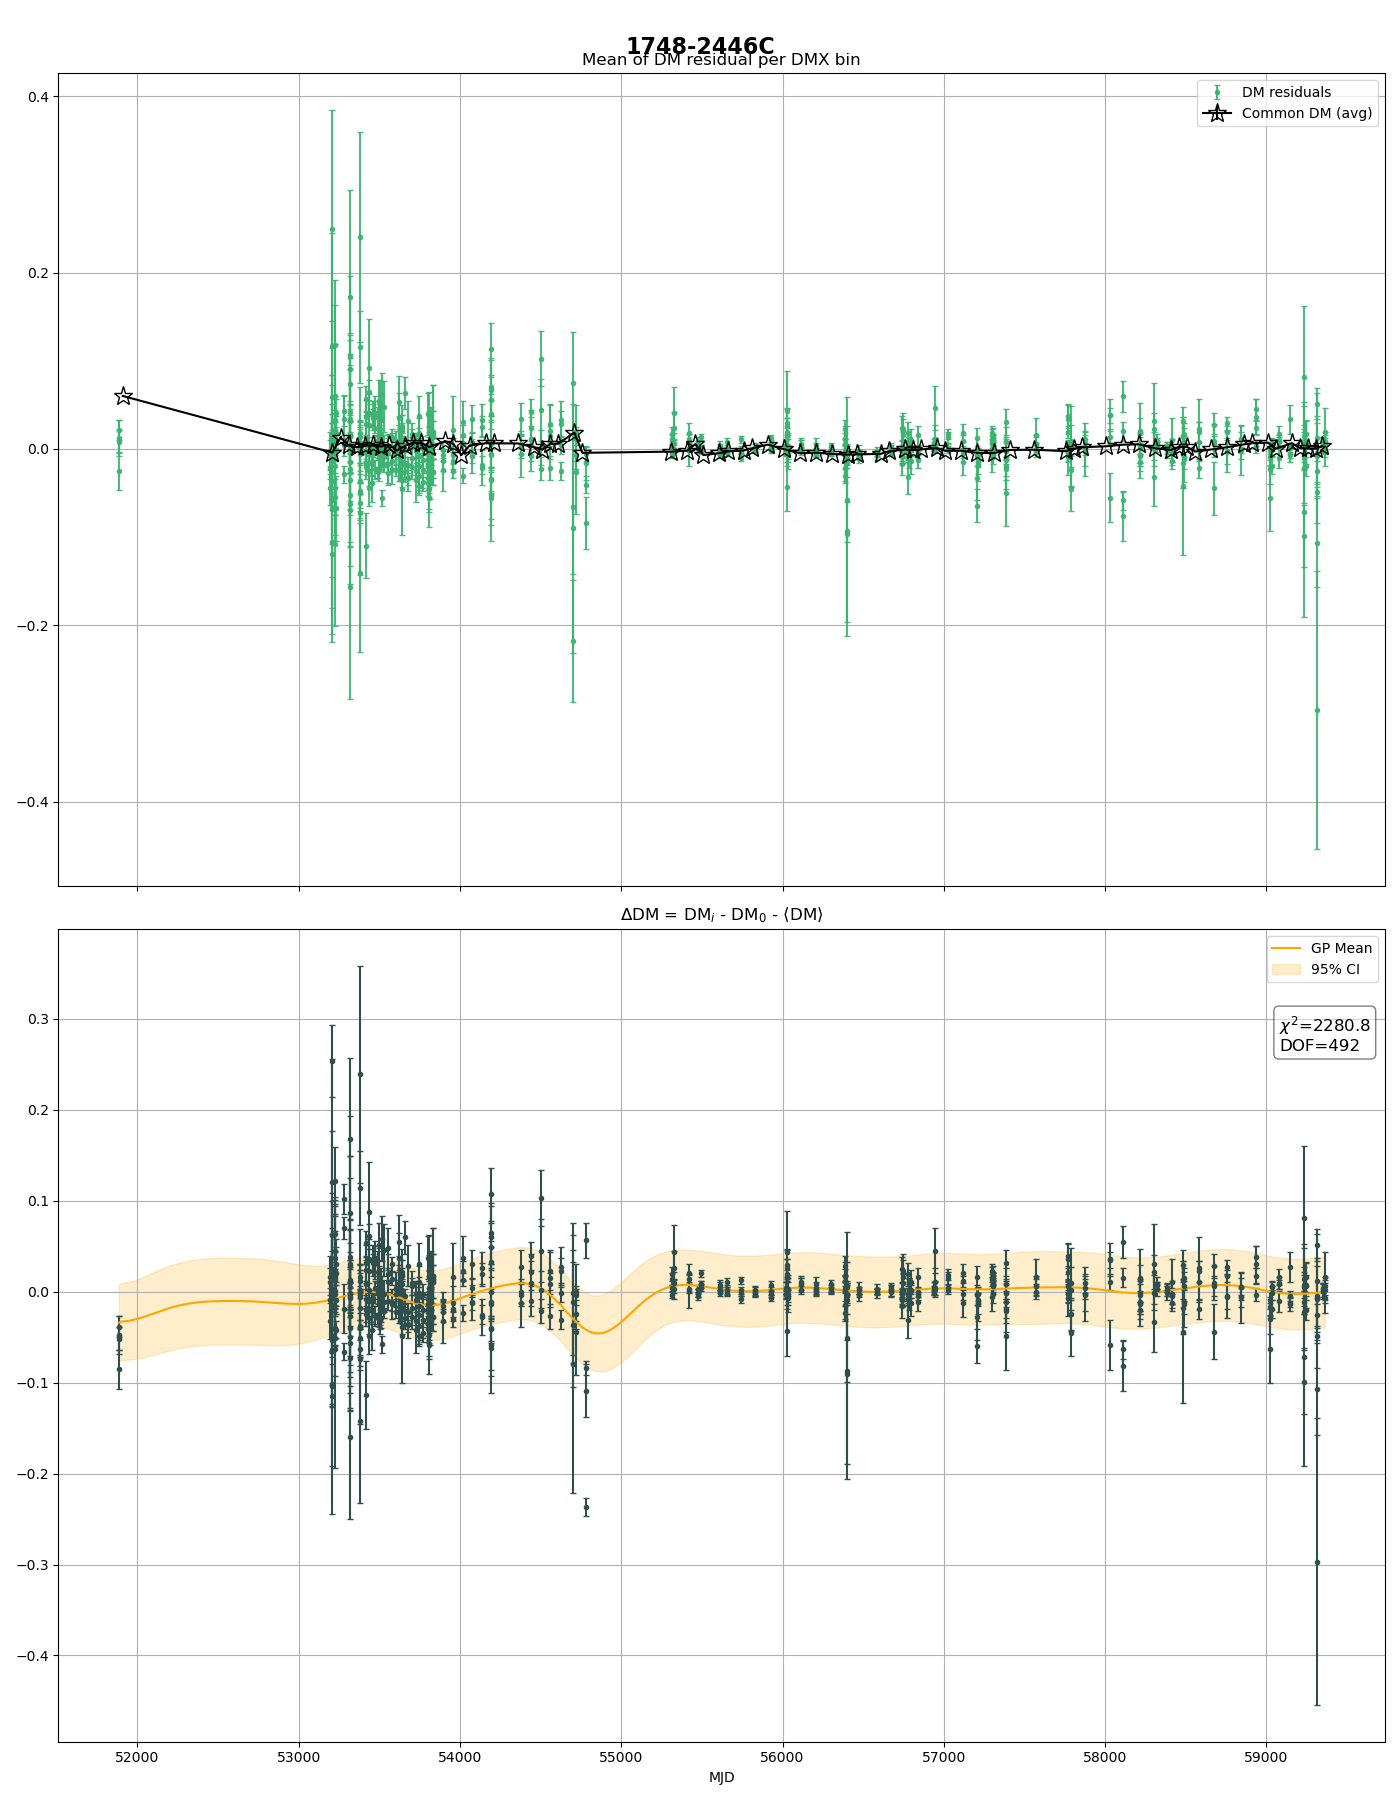

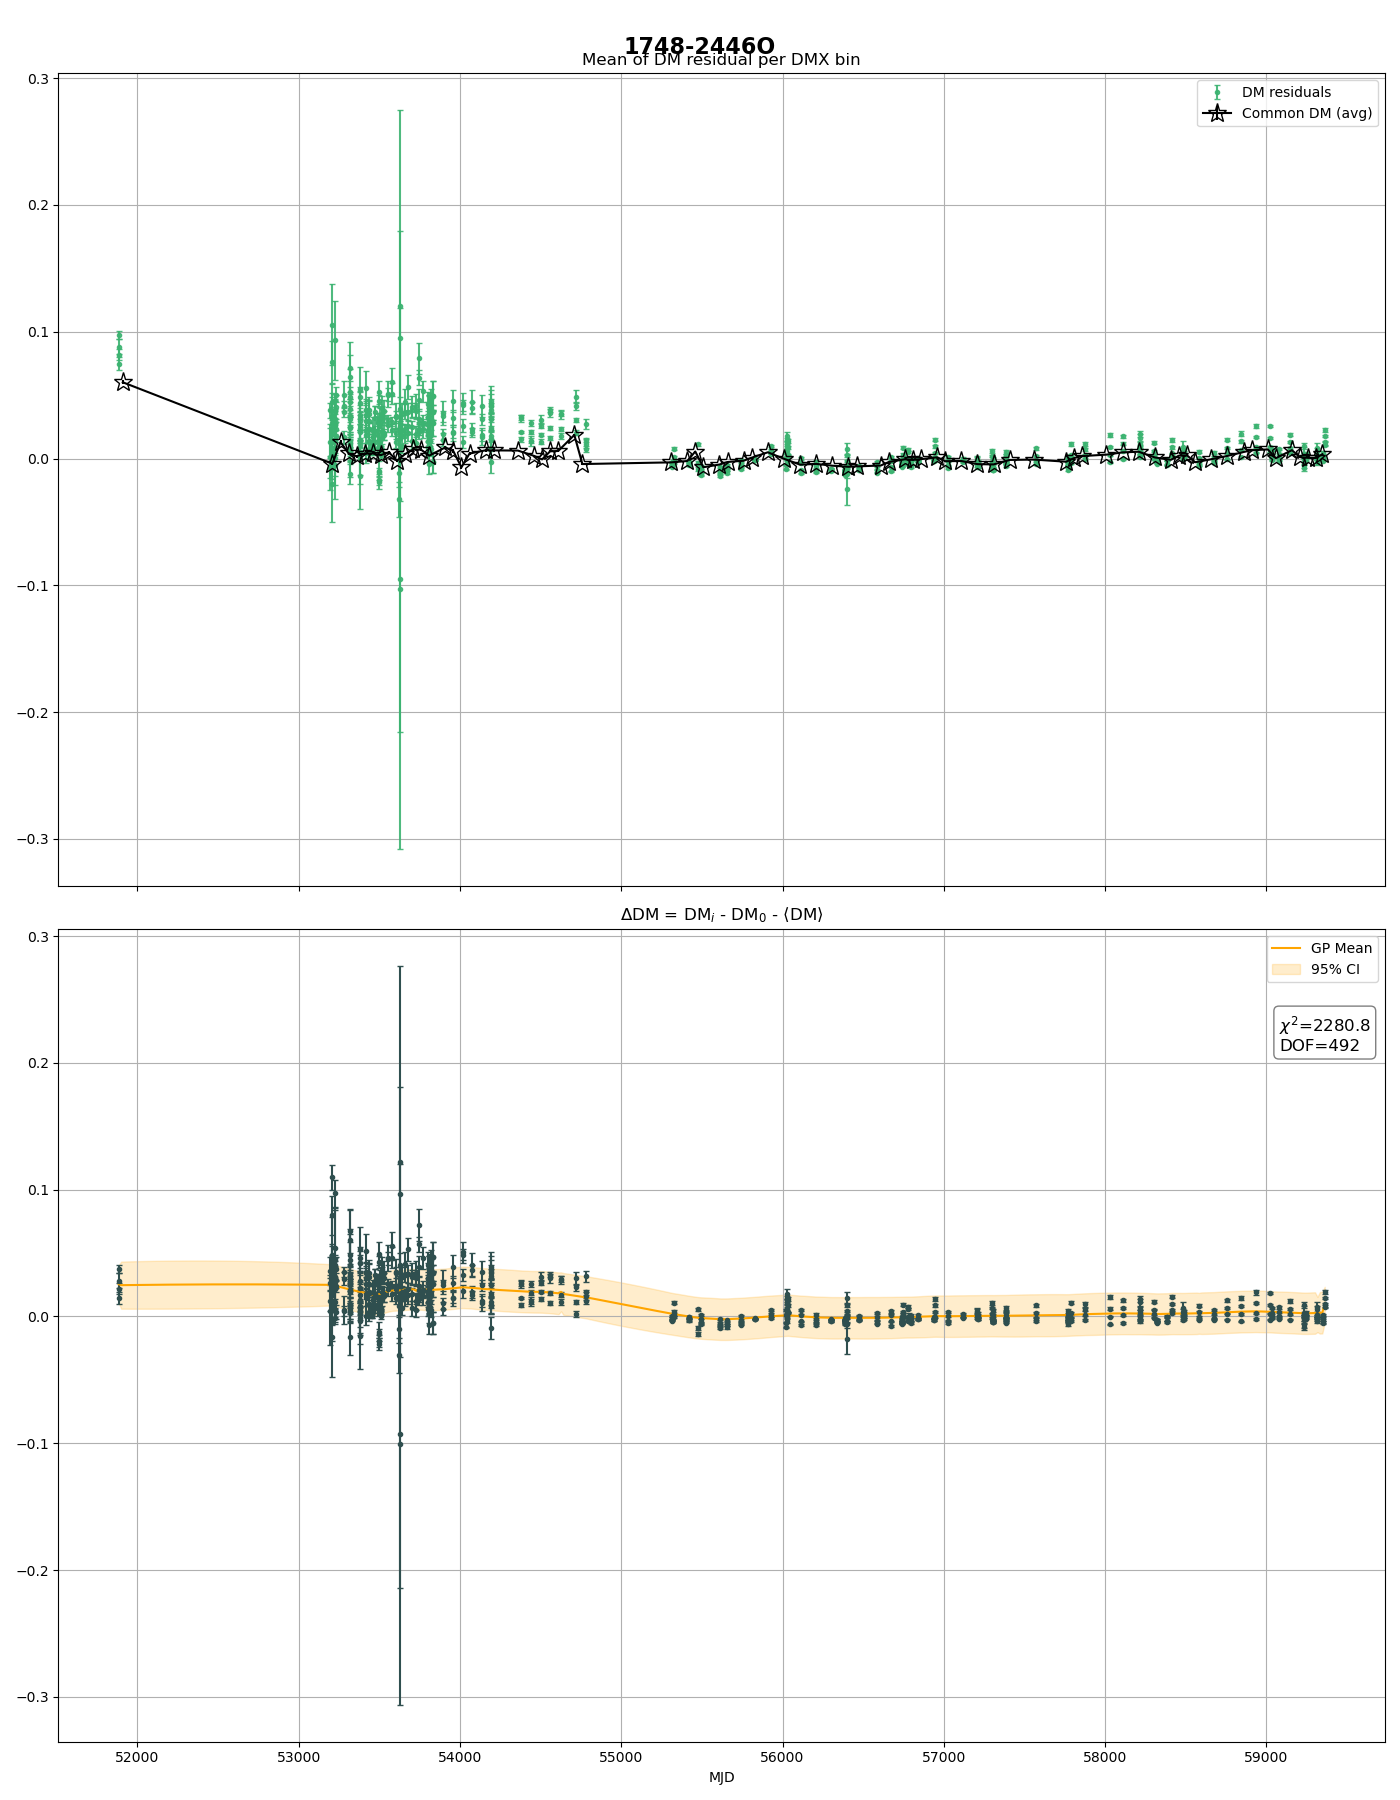

WARNING  (pint.logging                  ): /home/uwm/vleescho/Data15/vleescho/conda/envs/IPTA_Env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:419 ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.


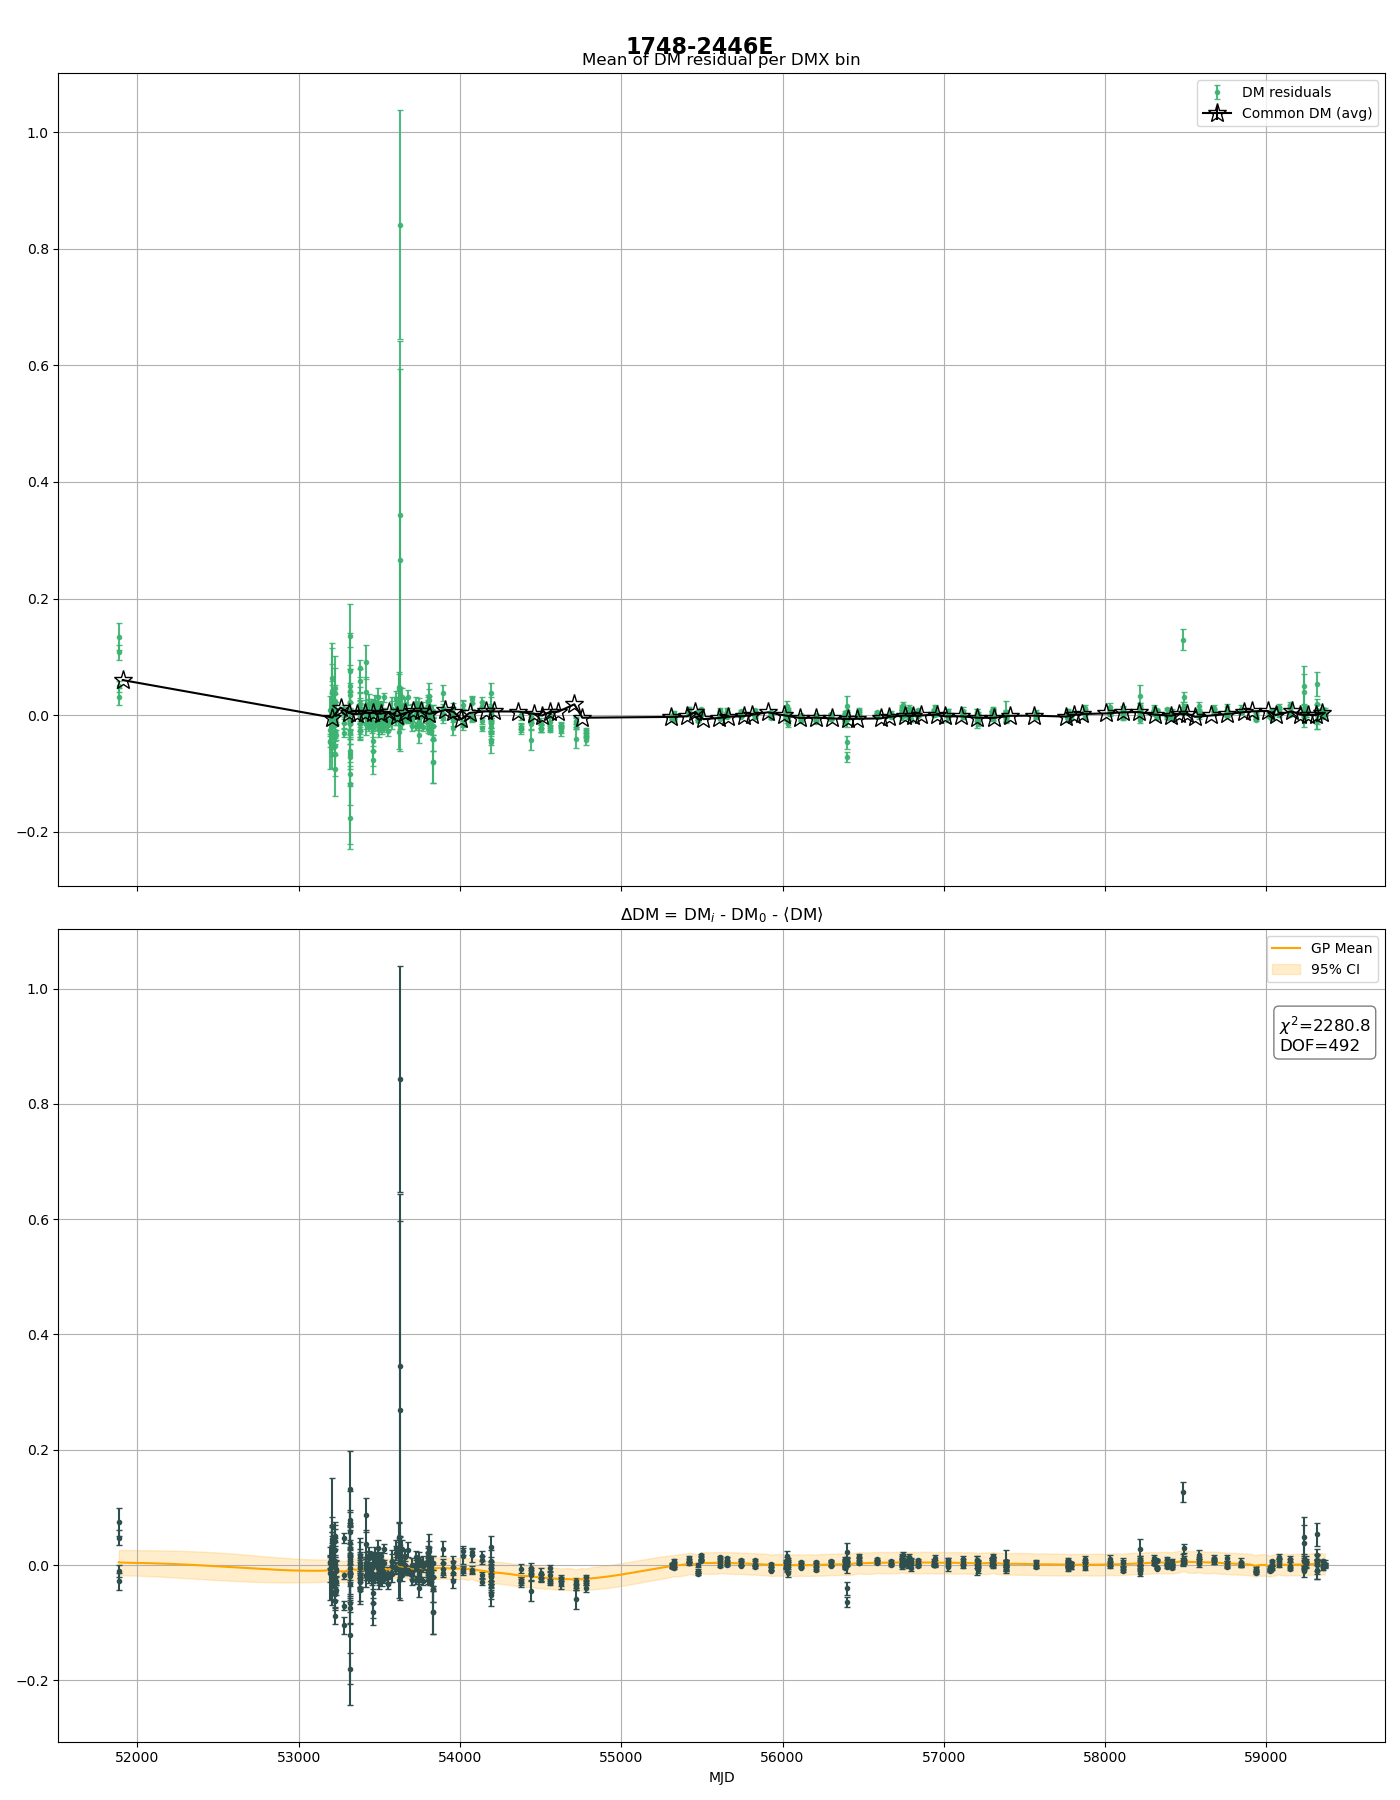

WARNING  (pint.logging                  ): /home/uwm/vleescho/Data15/vleescho/conda/envs/IPTA_Env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:419 ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.


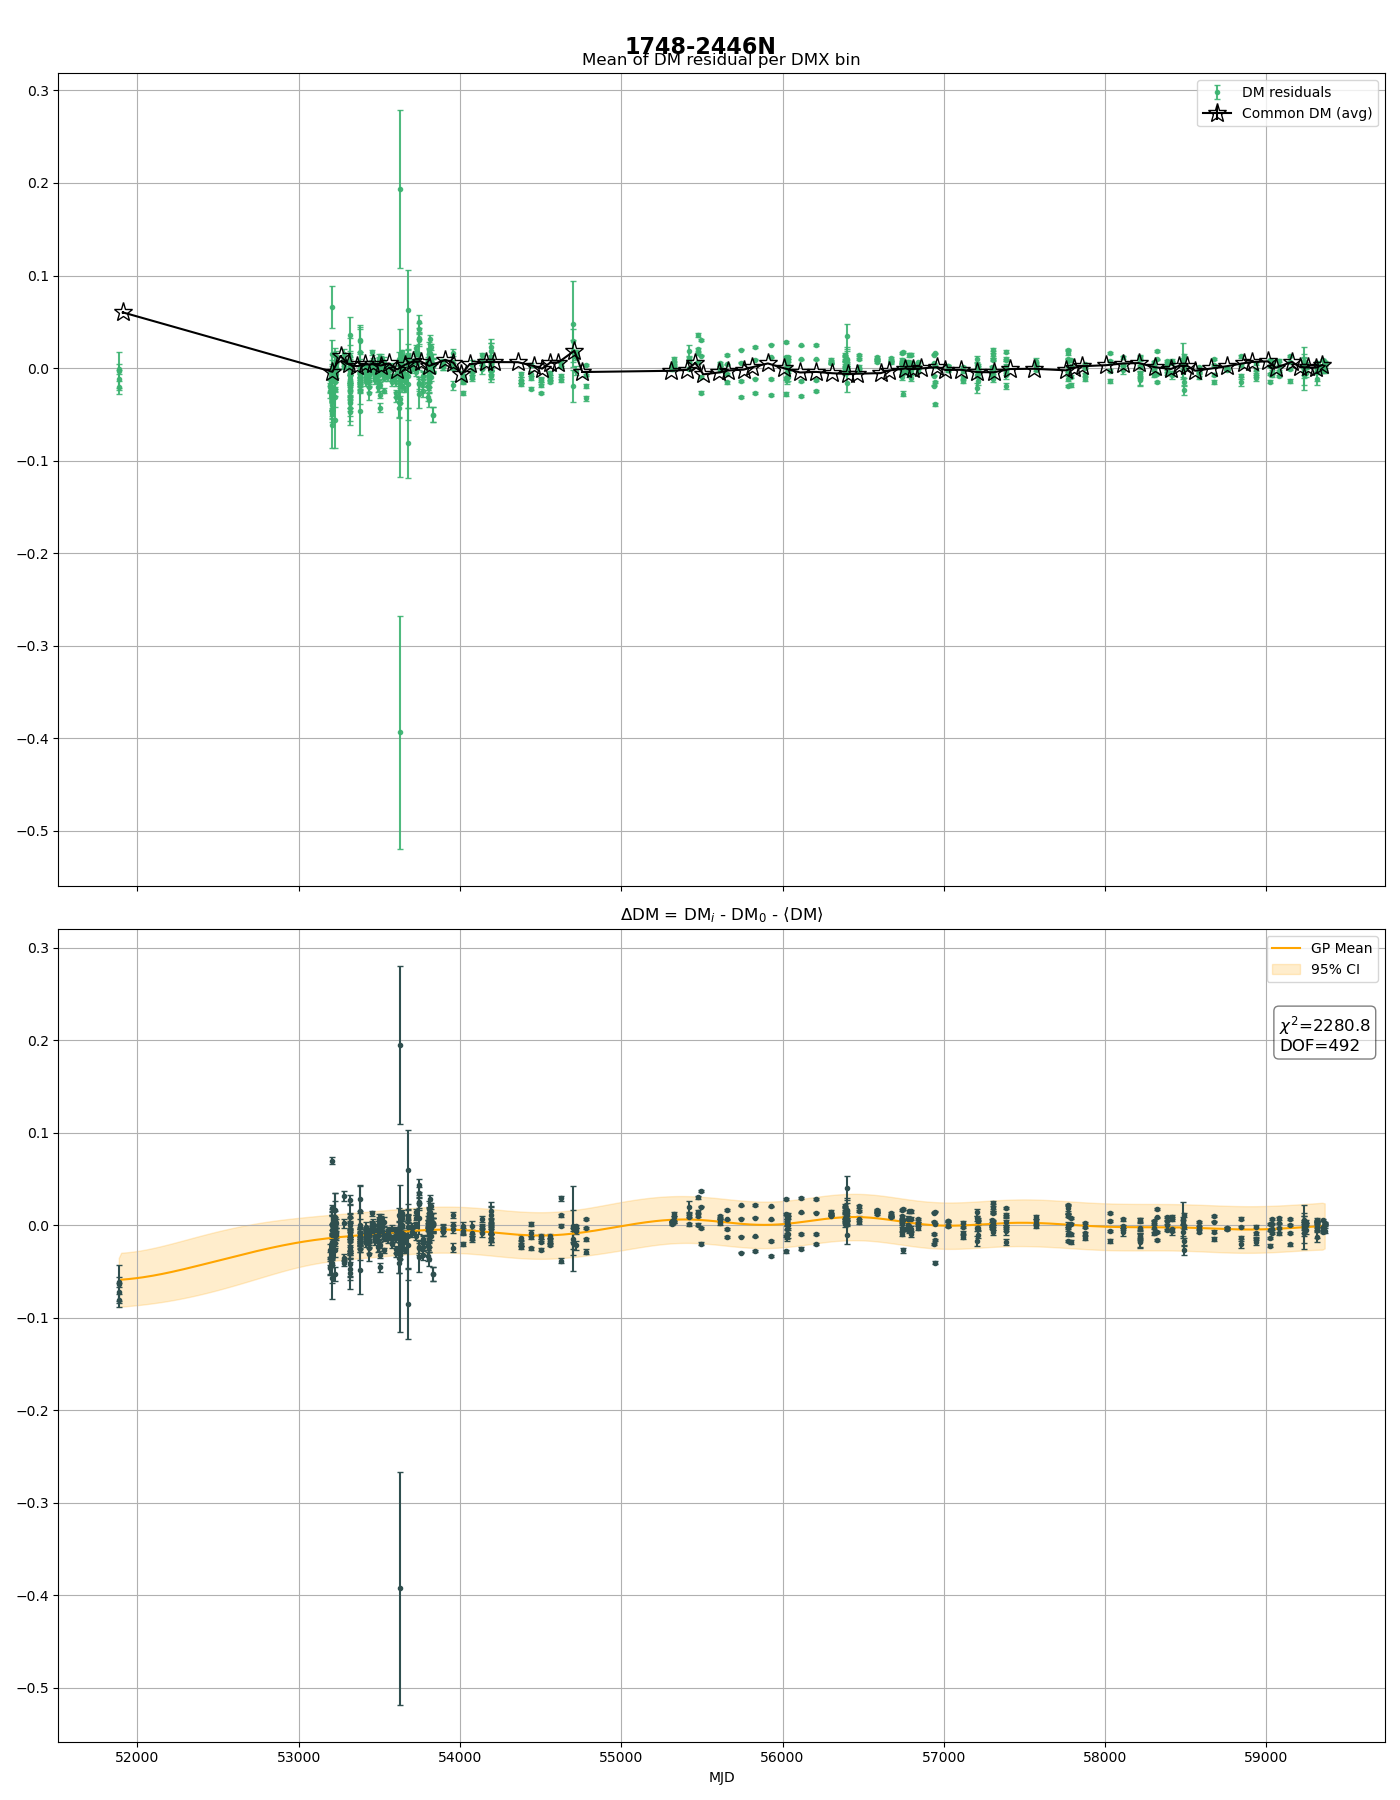

WARNING  (pint.logging                  ): /home/uwm/vleescho/Data15/vleescho/conda/envs/IPTA_Env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:429 ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.


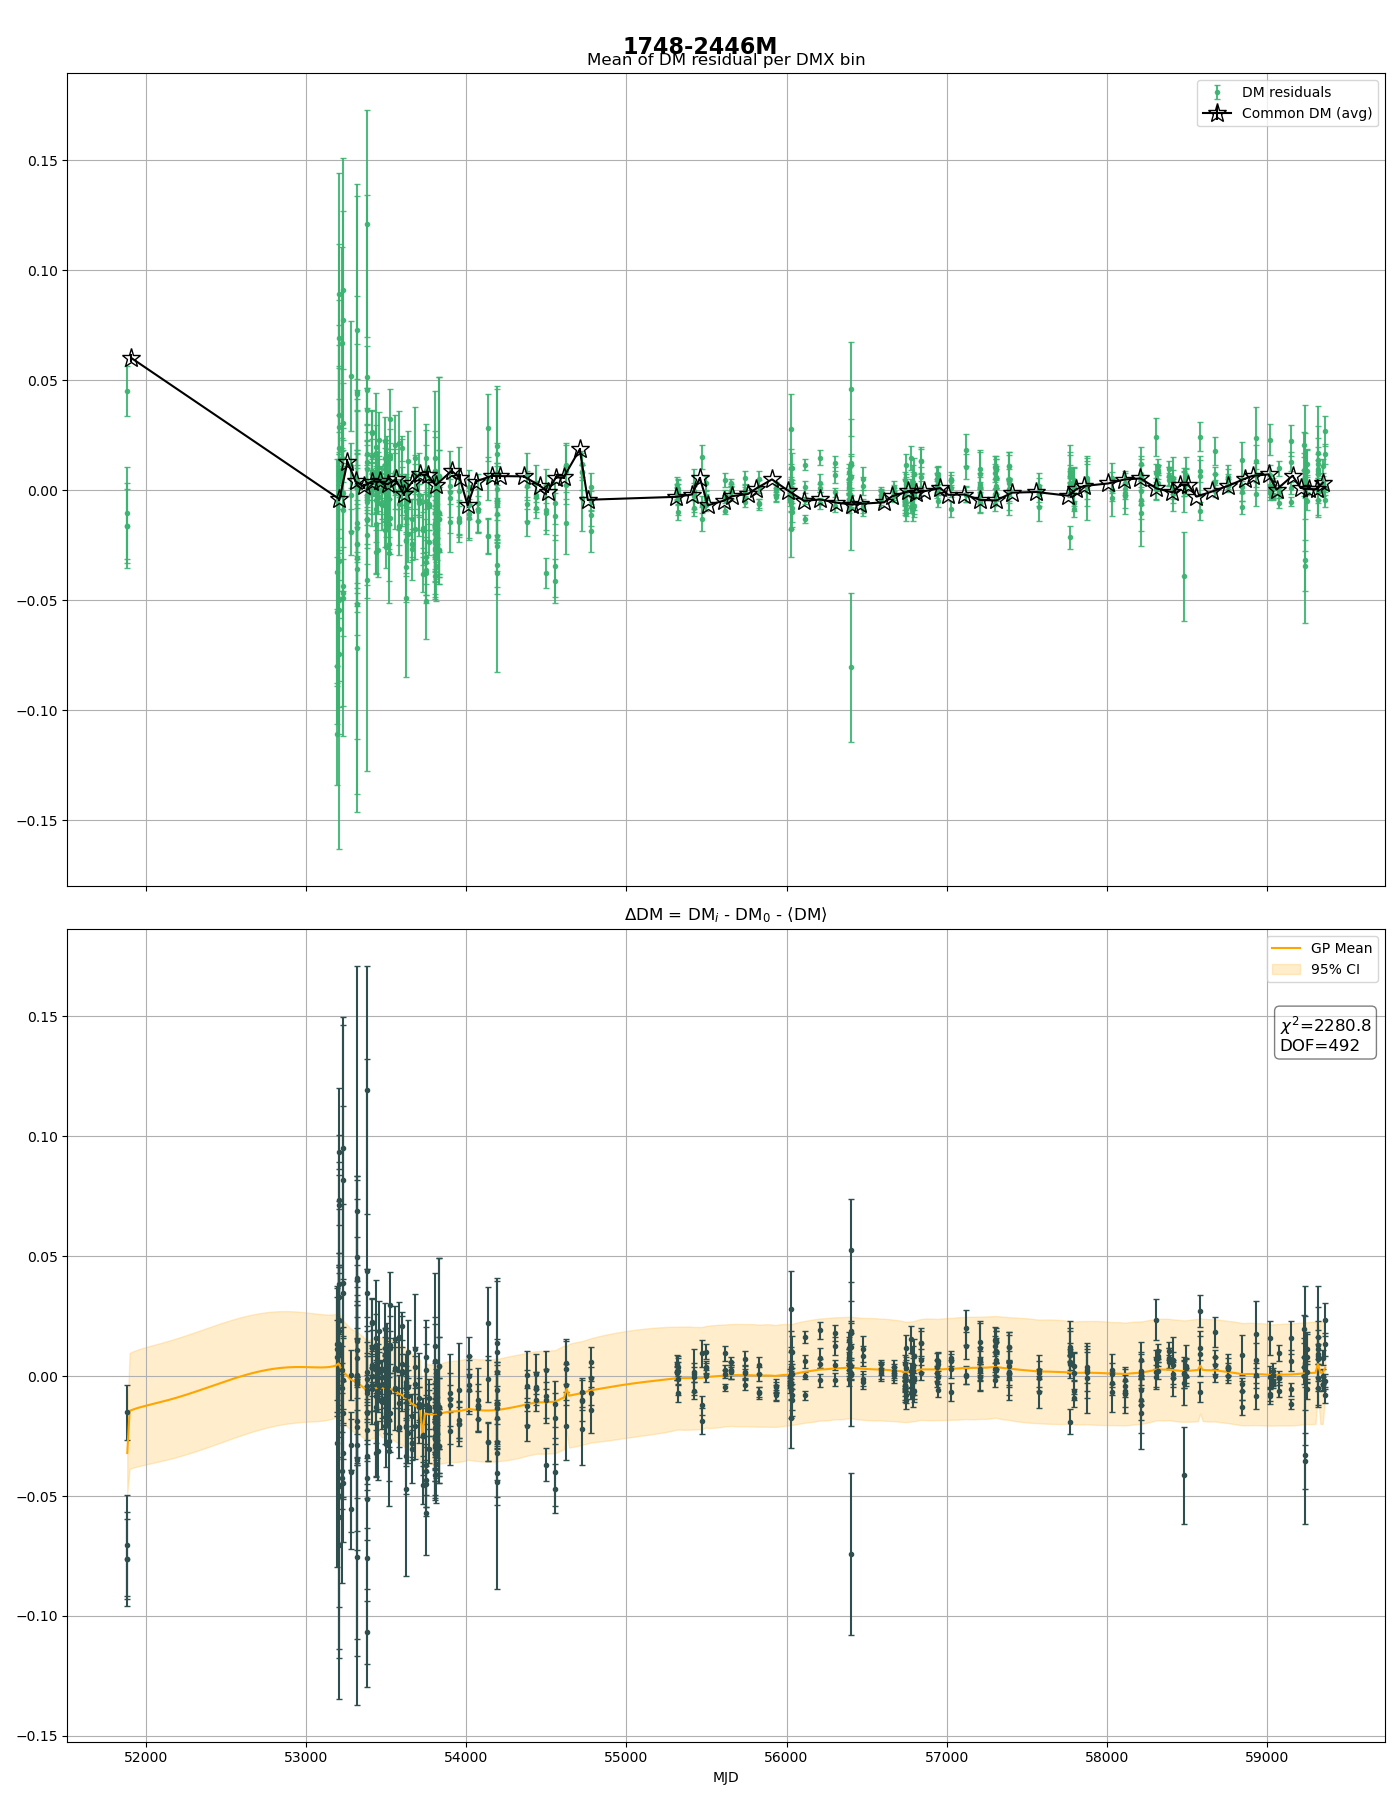

In [6]:
# ---------- GP FIT FOR EACH PULSAR ----------                                                                                
commonDM = np.genfromtxt("commonDM_Ter5data_5psrs.txt", names=True, dtype=None, encoding=None)
mean_dm = commonDM['Avg_DM']
chi2_cGP_list = []

results_summary = []
for r in results_DMX:
    dmresid_perbin_meanDM = []
    for i, bin_dm_resid in enumerate(r["dm_resid_perbin"]):
        if len(bin_dm_resid) > 0:
            subtracted_bin = bin_dm_resid - mean_dm[i]
            dmresid_perbin_meanDM.append(subtracted_bin)
        else:
            dmresid_perbin_meanDM.append(np.array([]))

    dmresid_perbin_meanDM_flat = np.concatenate(dmresid_perbin_meanDM)
    
    # Fitting the GP Regression to the data
    X = r['toas'].get_mjds().value[:, np.newaxis]
    y = dmresid_perbin_meanDM_flat[:, np.newaxis]
    err = r["dm_resid_err"]

    kernel = (1.0 * RBF(length_scale=500) +
              1.0 * RationalQuadratic(length_scale=50, alpha=1.0) +
              1.0 * Matern(length_scale=20, nu=0.5) +
              WhiteKernel(noise_level=1))

    gp = GaussianProcessRegressor(kernel=kernel, alpha=err**2, n_restarts_optimizer=10)
    gp.fit(X, y)
    X_pred = np.linspace(X.min(), X.max(), 500)[:, np.newaxis]
    y_pred, sigma = gp.predict(X_pred, return_std=True)

    chi2_cGP = np.sum(((y.flatten() - gp.predict(X).flatten()) / err)**2)
    dof_cGP = len(y) - len(kernel.theta)
    chi2_red_cGP = chi2_cGP/dof_cGP

    chi2_cGP_list.append(chi2_cGP)
    
    # Save 2-panel plot
    fig, ax = plt.subplots(2, 1, figsize=(14, 18))
    ax[0].errorbar(r['toas'].table['mjd_float'], r['dm_resid'], yerr=err, fmt=".", capsize=2, alpha=0.9, color='mediumseagreen', label='DM residuals')
    ax[0].errorbar(r["epochs"], mean_dm, yerr=commonDM['Avg_Error'], fmt="*-", label="Common DM (avg)", 
                   color='black', markeredgecolor='black', markerfacecolor='None', markersize=14)
    ax[0].set_title("Mean of DM residual per DMX bin")
    ax[0].tick_params(labelbottom=False)
    ax[0].legend() 
    ax[0].grid(True) 
    
    ax[1].errorbar(r['toas'].table['mjd_float'], dmresid_perbin_meanDM_flat, yerr=err, fmt=".", color='darkslategray', capsize=2)
    ax[1].plot(X_pred, y_pred, color='orange', label='GP Mean')
    ax[1].fill_between(X_pred.ravel(), y_pred.ravel() - 1.96 * sigma,
                       y_pred.ravel() + 1.96 * sigma, alpha=0.2, color='orange',label='95% CI')
    ax[1].figure.text(0.92, 0.85, f"$\\chi^2$={chi2:.1f}\nDOF={dof}", transform=ax[1].transAxes,
                      fontsize=12, bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
    ax[1].set_title(r"$\Delta$DM = DM$_i$ - DM$_0$ - $\langle$DM$\rangle$")
    ax[1].set_xlabel("MJD")
    ax[1].legend() 
    ax[1].grid(True)    

    plt.savefig(f"{r['name']}_common+GP.pdf", dpi=300, bbox_inches="tight")
    plt.subplots_adjust(top=0.95)
    fig.suptitle(f"{r['name']}", fontsize=16, fontweight="bold")
    fig.tight_layout()
    plt.show()

    # Save results                                                                                                             
    results_summary.append({
        "PSR": r["name"],
    	"chi2": chi2_cGP,
        "dof": dof_cGP,
        "chi2_red": chi2_red_cGP
    })

In [10]:
#Print summary results for the DMX model
print(f"{'Pulsar':<12} {'Chi2_DMX':>10} {'DOF_DMX':>10} {'Chi2_red_DMX':>12}")
print("-" * 46)
for r in results_DMX:
    print(f"{r['name']:<12} {r['chi2']:10.2f} {r['dof']:10} {r['chi2_red']:12.3f}")

total_chi2_DMX = np.sum(chi2_DMX_list)
num_psrs = len(pars)
k_DMX = dmx_epoch_count * num_psrs
total_toas = sum(len(toas) for toas in all_toas_list)

AIC_DMX = 2 * k_DMX + total_chi2_DMX
BIC_DMX = k_DMX * np.log(total_toas) + total_chi2_DMX 

print(f"\nTotal chi-squared DMX model: {total_chi2_DMX:.2f}")
print(f"\nNumber of free parameters (k): {k_DMX}")
print(f"\nTotal number of observations (toas): {total_toas}")
print(f"\nTotal AIC DMX_model: {AIC_DMX:.2f}")
print(f"\nTotal BIC DMX_model: {BIC_DMX:.2f}")

Pulsar         Chi2_DMX    DOF_DMX Chi2_red_DMX
----------------------------------------------
1748-2446C      3732.89        504        7.407
1748-2446O     46894.37        503       93.229
1748-2446E     13289.76        495       26.848
1748-2446N    109465.20        518      211.323
1748-2446M      2280.77        492        4.636

Total chi-squared DMX model: 175662.99

Number of free parameters (k): 380

Total number of observations (toas): 2892

Total AIC DMX_model: 176422.99

Total BIC DMX_model: 178691.48


In [11]:
#Print summary results for the common DM + GP model
print(f"{'Pulsar':<12} {'Chi2_cGP':>10} {'DOF_cGP':>10} {'Chi2_red_cGP':>12}")
print("-" * 46)
for res in results_summary:
    print(f"{res['PSR']:<12} {res['chi2']:10.2f} {res['dof']:10} {res['chi2_red']:12.3f}")

total_chi2_cGP = np.sum(chi2_cGP_list)
num_GP_params = 6
k_cGP = dmx_epoch_count + (num_psrs * num_GP_params)

AIC_cGP = 2 * k_cGP + total_chi2_cGP
BIC_cGP = k_cGP * np.log(total_toas) + total_chi2_cGP

print(f"\nTotal chi-squared commonDM + GP model: {total_chi2_cGP:.2f}")
print(f"\nNumber of free parameters (k): {k_cGP}")
print(f"\nTotal number of observations (toas): {total_toas}")
print(f"\nTotal AIC common DM + GP model: {AIC_cGP:.2f}")
print(f"\nTotal BIC common DM + GP model: {BIC_cGP:.2f}")

Pulsar         Chi2_cGP    DOF_cGP Chi2_red_cGP
----------------------------------------------
1748-2446C      2002.88        572        3.502
1748-2446O      9491.22        571       16.622
1748-2446E      2646.56        563        4.701
1748-2446N     26458.82        586       45.152
1748-2446M      1021.94        560        1.825

Total chi-squared commonDM + GP model: 41621.42

Number of free parameters (k): 106

Total number of observations (toas): 2892

Total AIC common DM + GP model: 41833.42

Total BIC common DM + GP model: 42466.21
